
## Flight Delays

The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights are published in DOT's monthly Air Travel Consumer Report and in this dataset of 2015 flight delays and cancellations.


## Data
Each entry of the flights.csv file corresponds to a flight.  More than 5,800,000 flights were recorded in 2015. These flights are described according to 31 variables. Further details of these variables can be found <a href='https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time'>here</a>, if you are interested (not needed to answer these questions). 


 

|          Name          | Type | DESCRIPTION |
|--------------------------------|---|----------------------------------------------------------------------|
| DATE                     | object | The date in python datetime format |
| MONTH                     | int64 | The month of the year(1-12) |
| DAY                       | int64 | The day of the month |
| DAY_OF_WEEK               | int64 | The day of the week(1-7, MON-SUN) |
| AIRLINE                  | object | An identifier for the airline |
| FLIGHT_NUMBER             | int64 | The flight number |
| TAIL_NUMBER              | object | The tail number (aircraft) corresponding to this flight |
| ORIGIN_AIRPORT           | object | The code for origin airport |
| DESTINATION_AIRPORT      | object | The code for destination airport |
| SCHED_DEP                | object | The departure time in python datetime.time format |
| SCHED_ARR                | object | The arrival time in python datetime.time format |
| DEPARTURE_DELAY         |  float64| The delay incurred at the origin  (mins) |
| ARRIVAL_DELAY           | float64 | The delay when the flight reached the (mins) destination |
| DISTANCE                  | int64 | Distance in miles between origin and destination |
| SCHEDULED_TIME          | float64 | Scheduled time of flight (minutes) |
| ELAPSED_TIME            | float64 | Actual time of flight (minutes) |
| AIR_SYSTEM_DELAY        | float64 | What part of the delay was NASD?(mins) |
| SECURITY_DELAY          | float64 | What part of the delay was due to security problems? (mins) |
| AIRLINE_DELAY           | float64 | What part of the delay is due to the airline? (mins) |
| LATE_AIRCRAFT_DELAY     | float64 | What part of the delay is due to previous flight(s) being late(mins) |
| WEATHER_DELAY           | float64 | Delay due to extreme weather events(min) |

You can read more about the various weather delays [here](https://www.rita.dot.gov/bts/help/aviation/html/understanding.html) if you are so inclined.



## Data/Caveats

The data file, flights.csv, is found <a href="https://drive.google.com/file/d/0B9dVesTppCgHY0IwZHk3SGhjd00/view?usp=sharing">here</a> (note, it is about 70MB). 

This data is already preprocessed, reduced, partially cleaned and therefore not identical to the original dataset.

## Problem Description

We will build two separate models: one model that classifies whether a flight will be delayed and a second model that predicts the length of delay given that a flight is truly delayed. Only consider models taught in class so far. 

** Consider the following: **
This is a large dataset; think of strategies on how to solve this problem. Create a manageable subsample of the data that you can use to train and test/validate, but eventually you should predict on all the data (excluding the training set).

### Questions
1. (5pts) Create a new variable, `DELAY_OR_NOT`: a boolean/indicator variable which indicates any arrival delay under 15 mins as a 0, and any delay at or above 15 mins as a 1 (`ARRIVAL_DELAY >= 15`).
2. (5pts) Make sure you understand the data variable descriptions before you start the analysis. Consider all the columns and determine and list which of these predictors should not be used. 
3. (15pts) Perform EDA to gain intuition of the factors that affect delay and provide visuals: do delays vary across airlines, or time of departure, or airport (do, at the very least, Chicago (ORD), Boston (BOS), and your favorite another airport), or airport traffic?
4. (20pts) Build a classification model that classifies delays according to `DELAY_OR_NOT`. This is an unbalanced dataset, thus consider the appropriate performance metric when reporting your results. 
5. (5pts) Given your model, comment on the importance of factors as related to whether a flight is delayed.
6. (5pts) Evaluate your model(s) on your test set, and finally provide a visual to show which airlines are predicted to have the most delays using all the data excluding the training and test set. 
7. (15pts) Build a regression model that predicts the length of delay (on the log scale) given that a flight is truly delayed.
8. (20pts) Write a report (in the last markdown cell in your notebook with your findings (without code)). Describe the main design decisions you have made with justifications. Clearly explain your methodology and results. This should not be more than 300 words. You may use up to 5 diagrams.



In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
from sklearn.preprocessing import PolynomialFeatures
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from IPython.display import Image
from IPython.display import display
from datetime import datetime, date, time
from scipy import stats
import math
%matplotlib inline

/Users/emilychen1/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Question 1

In [50]:
df = pd.read_csv('cs109a_midterm.csv')

# Generate DELAY_OR_NOT column & select only relevant variables
df['DELAY_OR_NOT'] = np.where(df['ARRIVAL_DELAY'] >= 15, 1, 0)
numerical_columns = ['SCHED_DEP','SCHED_ARR','DEPARTURE_DELAY',
                     'DISTANCE','SCHEDULED_TIME']
categorical_columns = ['MONTH','DAY','DAY_OF_WEEK','AIRLINE',
                       'ORIGIN_AIRPORT','DESTINATION_AIRPORT']

def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

df['SCHED_DEP'] = df['SCHED_DEP'].apply(get_sec)
df['SCHED_ARR'] = df['SCHED_ARR'].apply(get_sec)

df.head()

,DATE,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHED_DEP,...,ARRIVAL_DELAY,DISTANCE,SCHEDULED_TIME,ELAPSED_TIME,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DELAY_OR_NOT
0,2015-09-19,9,19,6,AA,394,N3FMAA,ORD,LGA,26100,...,1.0,733,135.0,127.0,NaN,NaN,NaN,NaN,NaN,0
1,2015-10-28,10,28,3,AA,375,N4YDAA,11298,13342,72900,...,-31.0,853,149.0,118.0,NaN,NaN,NaN,NaN,NaN,0
2,2015-08-19,8,19,3,MQ,3648,N512MQ,XNA,ORD,44520,...,-21.0,522,108.0,88.0,NaN,NaN,NaN,NaN,NaN,0
3,2015-12-01,12,1,2,WN,4096,N912WN,PHX,BWI,40800,...,-14.0,1999,260.0,235.0,NaN,NaN,NaN,NaN,NaN,0
4,2015-09-15,9,15,2,WN,285,N7718B,MCI,DEN,51000,...,-12.0,533,105.0,97.0,NaN,NaN,NaN,NaN,NaN,0


In [51]:
# Split train and test sets for visualization

np.random.seed(9001)

# split data into 5% training & test, 95% validation
model_df, validation_df = train_test_split(df, train_size=0.05)

# split model data into 50% training, 50% test
train_df, test_df = train_test_split(model_df, train_size=0.5)

### Question 2

The following predictors should be used in the model:

#### Delay Model: 
MONTH, DAY, DAY_OF_WEEK, AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, SCHED_DEP, SCHED_ARR, DEPARTURE_DELAY, DISTANCE, SCHEDULED_TIME

#### Lenth of Delay Model:
(subset of data where ARRIVAL_DELAY $\geq$ 15)

DATE, MONTH, DAY, DAY_OF_WEEK, AIRLINE, ORIGIN_AIRPORT, DESTINATION_AIRPORT, SCHED_DEP, SCHED_ARR, DEPARTURE_DELAY, DISTANCE, SCHEDULED_TIME

We remove 'DATE' as month and day are already taken into account by those predictors and year is insignificant since all the data are from the same year. 'FLIGHT_NUMBER' and 'TAIL_NUMBER' are also thrown out because they are usually arbitrarily assigned (i.e. there is no signifance in these numbers). We also remove 'ARRIVAL_DELAY' as we are precisely trying to predict important features of this response variable. 'ELAPSED_TIME' is also thrown out because it can be almost directly calculated from the other predictors.

### Question 3

After plotting various features of the data, we can make some first-glance conjectures.
- The histogram plots of various lengths of arrival delays shows some differences among airlines. For example, Airline NK has many short delays while Airline EV has a larger, more spead out pattern of lengths of arrival delays. Overall, it'll be interesting to explore the effect of airline on flight arrival delay.
- We next examine the time of departure and length of arrival delay, which make it evident that there are far fewer delays longer than 15 min than shorter. We also note that there are more $\geq 15$ as the day progresses, which is also expected given that there are few flights in the first few hours of the day. We also note some outliers (though few) in our data set.
- The succeeding 2 plots show histograms for arrival delay for Chicago ORD, Boston BOS, San Franciso SFO, and New York JFK as both the origin airport and the destination airport. From the graphs, passengers leaving from Boston will likely experience delays while those arriving at San Francisco do too.
- We also visualize air traffic and arrival delay ('LATE_AIRCRAFT_DELAY') and see no distinct pattern currently. There may potentially be some connection between longer arrival delay and later time of day.

In [4]:
# Visualization function from HW 3
def plot_relevant_question(dataframe, ax, labels_to_use, criteria_label, 
                           criteria, boolean_query=True):
    df = dataframe.copy()
    
    if boolean_query:
        df['column_of_interest'] = df[criteria_label].isin(criteria)
        for g, group in df.groupby('column_of_interest'):
            group['ARRIVAL_DELAY'].plot(kind='hist', ax=ax, alpha=0.3, 
                                        label = labels_to_use[g])
        ax.legend(loc='best')
        
    else:
        for i, (g, group) in enumerate(df.groupby(criteria_label)):
            group['ARRIVAL_DELAY'].plot(kind='hist', ax=ax[i], bins=10, 
                                        alpha=0.3, label = labels_to_use[i])
            ax[i].set_title(labels_to_use[i])
            ax[i].set_xlim(0,400)

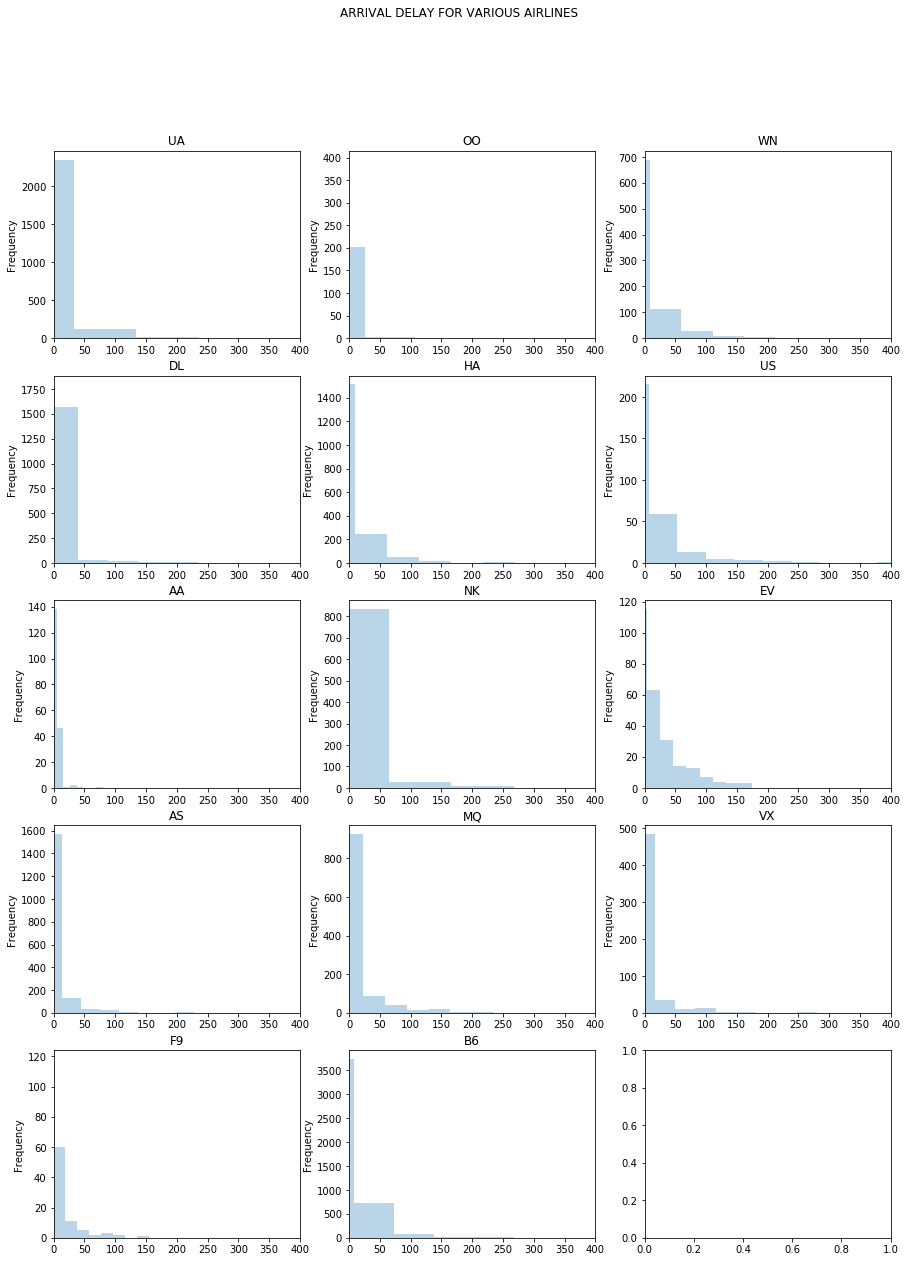

In [6]:
airlines = train_df['AIRLINE'].unique()

fig, ax = plt.subplots(int(math.ceil(len(airlines)/3)),3,figsize=(15,20))
plt.suptitle('ARRIVAL DELAY FOR VARIOUS AIRLINES')
ax = ax.flatten()
plot_relevant_question(train_df, ax, airlines, 'AIRLINE', None, False)
plt.show()

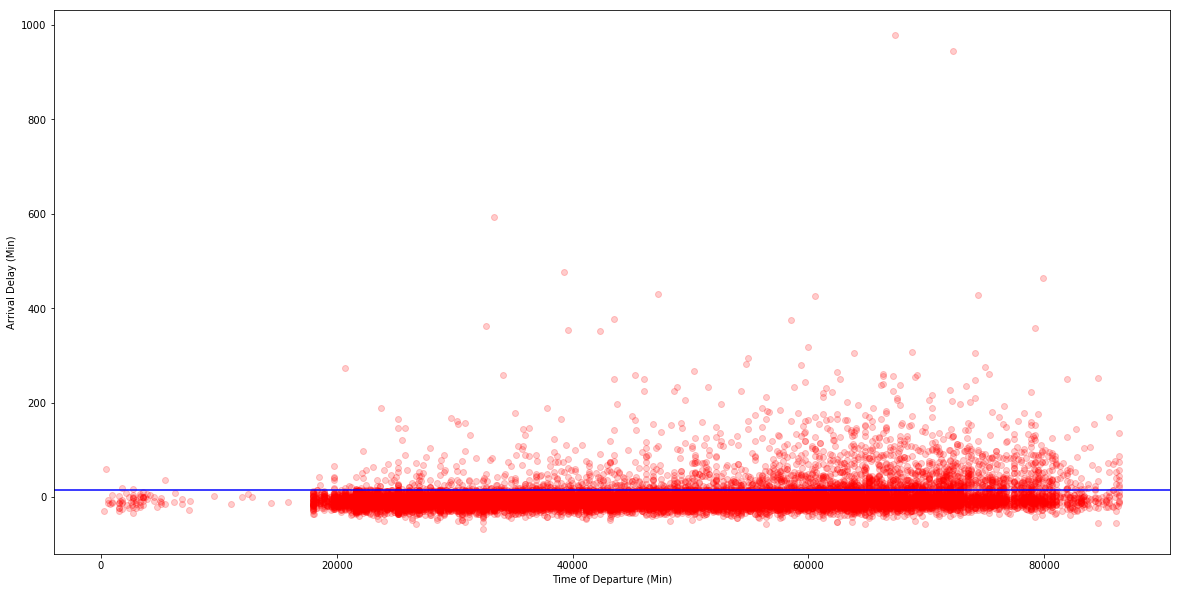

In [7]:
plt.figure(figsize=(20,10))
plt.ylabel('Arrival Delay (Min)')
plt.xlabel('Time of Departure (Min)')
plt.scatter(train_df['SCHED_DEP'].values, 
            train_df['ARRIVAL_DELAY'].values, alpha=0.2 , c='r')
plt.axhline(y=15, color='b', linestyle='-')
plt.show()

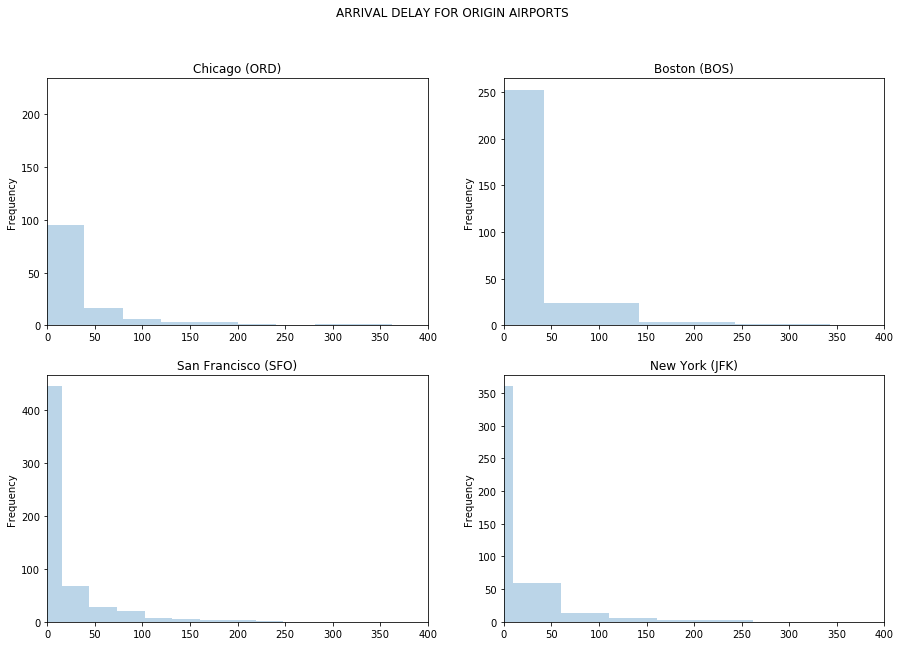

In [8]:
airports = ['ORD','BOS','SFO','JFK']

eda_df = train_df[train_df['ORIGIN_AIRPORT'].isin(airports)]
fig, ax = plt.subplots(2,2,figsize=(15,10))
plt.suptitle('ARRIVAL DELAY FOR ORIGIN AIRPORTS')
ax = ax.flatten()
plot_relevant_question(eda_df, ax, 
                       ['Chicago (ORD)', 'Boston (BOS)', 
                        'San Francisco (SFO)', 'New York (JFK)'], 
                       'ORIGIN_AIRPORT', None, False)

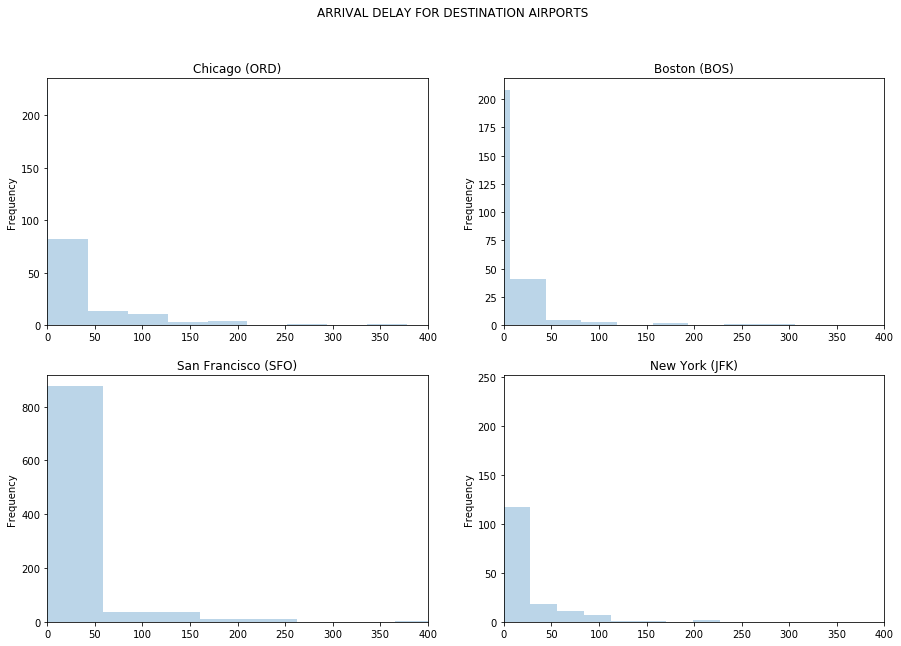

In [9]:
eda_df = train_df[train_df['DESTINATION_AIRPORT'].isin(airports)]
fig, ax = plt.subplots(2,2,figsize=(15,10))
plt.suptitle('ARRIVAL DELAY FOR DESTINATION AIRPORTS')
ax = ax.flatten()
plot_relevant_question(eda_df, ax, 
                       ['Chicago (ORD)', 'Boston (BOS)', 
                        'San Francisco (SFO)', 'New York (JFK)'], 
                       'DESTINATION_AIRPORT', None, False)

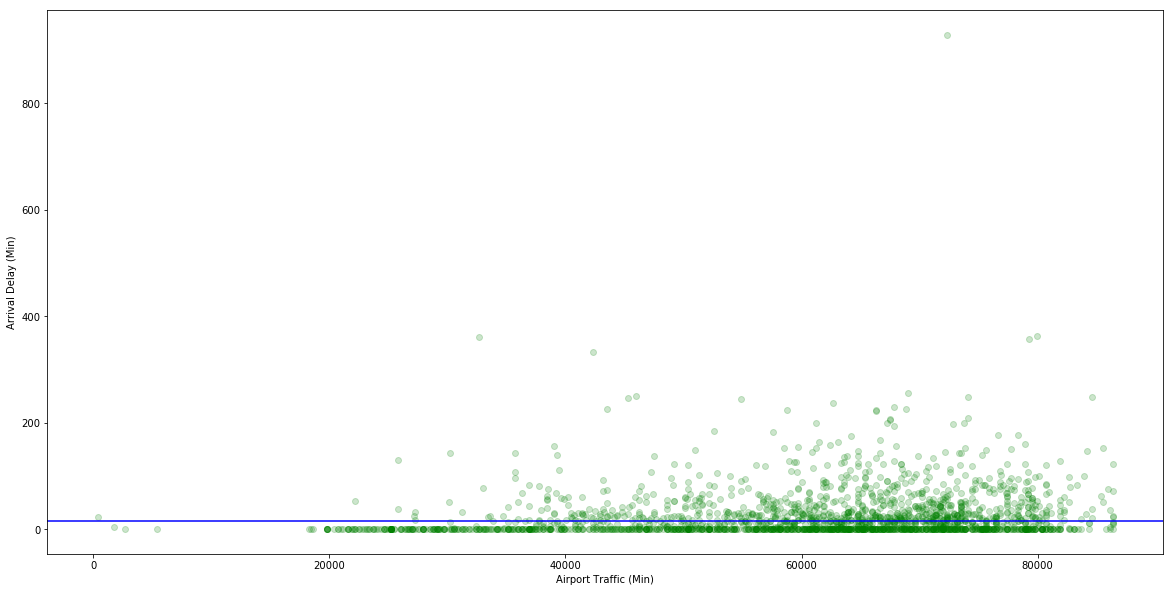

In [10]:
plt.figure(figsize=(20,10))
plt.ylabel('Arrival Delay (Min)')
plt.xlabel('Airport Traffic (Min)')
plt.scatter(train_df['SCHED_DEP'].values, 
            train_df['LATE_AIRCRAFT_DELAY'].values, 
            alpha=0.2 , c='g')
plt.axhline(y=15, color='b', linestyle='-')
plt.show()

### Question 4

The best model after fitting many different models below is the multilple logistic model, which has both the highest AUC (important for unbalanced data sets, where one value of the binary response variable is much more common than the other) and accuracy score. Details for development of this model are described in Question 8.

In [52]:
df = df[categorical_columns + numerical_columns + 
        ['DELAY_OR_NOT']]
df = pd.get_dummies(df, columns=categorical_columns, 
                    drop_first=True)

np.random.seed(9001)

# split data into 5% training & test, 95% validation
model_df, validation_df = train_test_split(df, train_size=0.05)

# split model data into 50% training, 50% test
train_df, test_df = train_test_split(model_df, train_size=0.5)

In [53]:
# Standardize numerical variables
mean = train_df[numerical_columns].mean()
std = train_df[numerical_columns].std()

train_df[numerical_columns] = 
    (train_df[numerical_columns] - mean)/std
test_df[numerical_columns] = 
    (test_df[numerical_columns] - mean)/std
validation_df[numerical_columns] = 
    (validation_df[numerical_columns] - mean)/std

train_df.head()

/Users/emilychen1/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,SCHED_DEP,SCHED_ARR,DEPARTURE_DELAY,DISTANCE,SCHEDULED_TIME,DELAY_OR_NOT,MONTH_2,MONTH_3,MONTH_4,MONTH_5,...,DESTINATION_AIRPORT_TYS,DESTINATION_AIRPORT_UST,DESTINATION_AIRPORT_VEL,DESTINATION_AIRPORT_VLD,DESTINATION_AIRPORT_VPS,DESTINATION_AIRPORT_WRG,DESTINATION_AIRPORT_WYS,DESTINATION_AIRPORT_XNA,DESTINATION_AIRPORT_YAK,DESTINATION_AIRPORT_YUM
509267,-0.307350,-0.230152,-0.269184,-0.233202,-0.149148,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
84944,-0.775952,-0.553629,0.969125,-0.410335,-0.449274,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
740319,-1.152948,-1.064382,-0.269184,-0.255133,-0.217359,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
646736,1.119596,1.097805,0.650703,-0.649885,-0.353780,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
364483,-1.029631,0.144400,-0.446085,2.933249,2.511059,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
X_train = train_df.loc[:, train_df.columns != 
                       'DELAY_OR_NOT']
y_train = train_df['DELAY_OR_NOT']
X_test = test_df.loc[:, test_df.columns != 
                     'DELAY_OR_NOT']
y_test = test_df['DELAY_OR_NOT']

X_validation = 
    validation_df.loc[:, validation_df.columns != 
                      'DELAY_OR_NOT']
y_validation = validation_df['DELAY_OR_NOT']

In [17]:
# Logistic Regression
logitm = LogisticRegression(C=100000)
logitm.fit(X_train, y_train)

print("Logistic Train Score: ", logitm.score(X_train, y_train))
print("Logistic Test Score: ", logitm.score(X_test, y_test))

Logistic Train Score:  0.969288873428
Logistic Test Score:  0.957115881534


In [18]:
# LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

print('LDA Train Score: ', lda.score(X_train, y_train))
print('LDA Test Score: ', lda.score(X_test, y_test))

/Users/emilychen1/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA Train Score:  0.953386671967
LDA Test Score:  0.948717948718


In [19]:
# QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

print('QDA Train Score: ', qda.score(X_train, y_train))
print('QDA Test Score: ', qda.score(X_test, y_test))

/Users/emilychen1/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QDA Train Score:  0.248173731551
QDA Test Score:  0.236185648976


In [56]:
# kNN
max_score = 0
max_k = 0 

for k in range(1,15):
    knn = KNeighborsClassifier(n_neighbors = k)
    score = cross_val_score(knn,X_train, y_train).mean()
    if score > max_score:
        max_k = k
        max_score = score
 

knn = KNeighborsClassifier(n_neighbors = max_k)
knn.fit(X_train, y_train)

print('KNN Train Score:', '(Best K is ' + str(max_k) +')',  
      knn.score(X_train, y_train))
print('KNN Test Score:', '(Best K is ' + str(max_k) +')',  
      knn.score(X_test, y_test))

Running the kNN model took too long to produce a robust one (iterating over enough values k to generate something substantial) for this large data set. This is probably not the ideal model for this problem.

In [85]:
# Decision Tree
depths = [i for i in range(2, 11)]
train_scores = []
test_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth)
    clf.fit(X_train,y_train)
    train_scores.append(clf.score(X_train,y_train))
    test_scores.append(clf.score(X_test,y_test))
    
total_scores = []
for depth in depths:
    clf = DecisionTreeClassifier(max_depth = depth)  
    # Perform 5-fold cross validation 
    score = cross_val_score(estimator=clf, X=X_train, 
                            y=y_train, cv=5)
    total_scores.append((depth, np.mean(score)))

optimal_depth = max(total_scores, key=lambda x:x[1])[0]
clf = DecisionTreeClassifier(max_depth=optimal_depth)
clf.fit(X_train,y_train)

print ('Decision Tree Train Score: (Depth %0.0f) ' 
       %optimal_depth, clf.score(X_train,y_train))
print ('Decision Tree Test Score: (Depth %0.0f) ' 
       %optimal_depth, clf.score(X_test,y_test))

Running the Decision Tree model took too long to produce a robust one (iterating over enough values for depth to generate something substantial) for this large data set. This is probably not the ideal model for this problem.

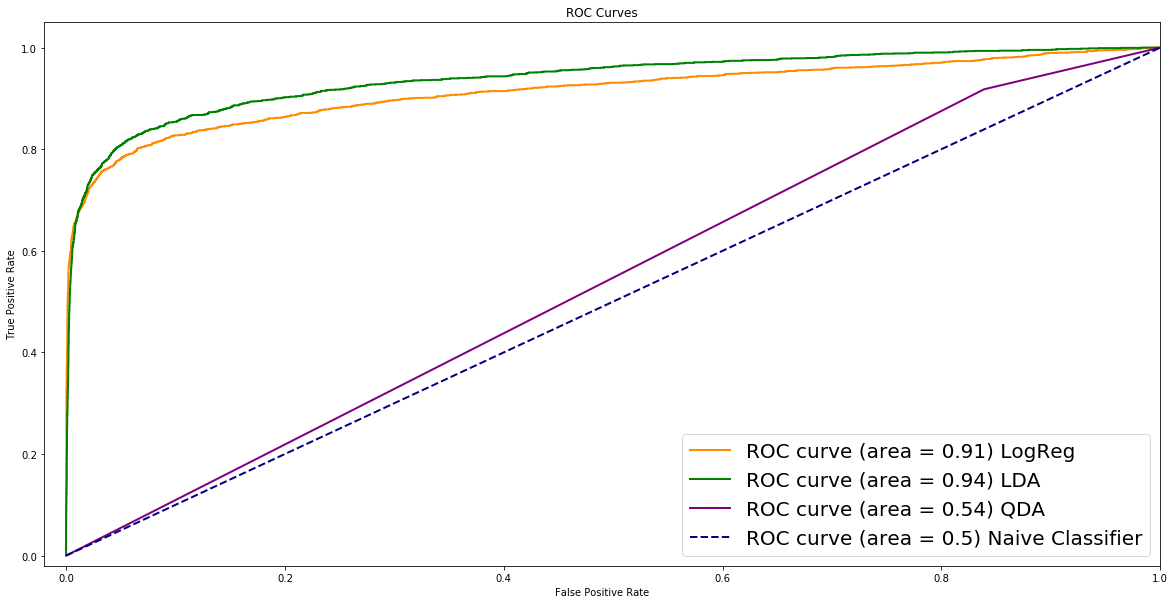

In [22]:
# Plot ROC curves & calculate AUC for various models

fitted_models = [logitm, lda, qda,]
titles = ['LogReg', 'LDA', 'QDA']
colors = ['darkorange','green','purple']

plt.figure(figsize=(20,10))
lw = 2

for i in range(len(fitted_models)):
    preds = fitted_models[i].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i],
         lw=lw, label='ROC curve (area = %0.2f) ' 
             % roc_auc + titles[i] )

fpr_2, tpr_2, thresholds_2 = 
    metrics.roc_curve(y_test, [0 for y in y_test])
roc_auc_2 = metrics.auc(fpr_2, tpr_2)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--',
         label ='ROC curve (area = 0.5) Naive Classifier')
plt.xlim([-0.02, 1.0])
plt.ylim([-0.02, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right", prop={'size':20})
plt.show()

### Question 5

The code below bootstraps 100 times within the training data to determine which predictors of the Multiple Logistic Model are statistically significant at the 0.05 level. 

Below, all 138 of these significant predictors are listed. We see that 'SCHED_DEP' has a large $\beta$ coefficient, indicating that time of departure is a large factor in whether or not a plane is delayed. In addition, some specific airports have large $\beta$ coeffients as well, inidicating that either leaving from or arriving at that particular airport also tends to cause one's flight to be delayed. Something interesting to note that quite a few months have negative $\beta$ coefficients and other months are not significant, indicating that taking a flight during some specific months may be less prone to delays as well.

In [23]:
# For the Logistic Model, which predictors are actually significant?

response_index = list(train_df).index('DELAY_OR_NOT')

# Initialize list of lists, each for the 100 values of each beta
betas = [[] for i in range(len(list(train_df)))]
    
# Boostrap 100 times to evaluate significance of the predictors
np.random.seed(9002)
for i in range(100):
    sample = resample(train_df.values, n_samples=100)
    x, y = [], []
    
    for ele in sample:
        y.append(ele[response_index])
        x.append([index for i, index in enumerate(ele) 
                  if i != response_index])
            
    logitm_cv = LogisticRegression(C=100000)
    logitm_cv.fit(x, y)
    model_coefs = logitm_cv.coef_[0]
    
    for i in range(len(model_coefs)):
        betas[i].append(model_coefs[i])
        
significant_predictors = []
for i in range(len(betas)):
    if stats.ttest_1samp(betas[i], 0.0).pvalue < .05:
        significant_predictors.append((i, list(train_df)[i], 
                                       logitm.coef_[0][i]))
    
print('Number of significant predictors:', 
      len(significant_predictors))
significant_predictors

Number of significant predictors: 138


/Users/emilychen1/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/emilychen1/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/emilychen1/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3126: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/emilychen1/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/emilychen1/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[(0, 'SCHED_DEP', 0.77308932700446209),
 (1, 'SCHED_ARR', -0.052613928581492449),
 (2, 'DEPARTURE_DELAY', 4.5479504869112546),
 (6, 'MONTH_2', -0.33598239483492037),
 (7, 'MONTH_3', -0.34240040711668573),
 (8, 'MONTH_4', -0.48494040790434723),
 (9, 'MONTH_5', 0.21952749549338443),
 (10, 'MONTH_6', -0.2842462938873021),
 (11, 'MONTH_7', -0.63278103615534453),
 (12, 'MONTH_8', -1.8296393853480823),
 (13, 'MONTH_9', -4.847895023597391),
 (14, 'MONTH_10', -1.1877695143811646),
 (16, 'MONTH_12', 0.25581042007828775),
 (18, 'DAY_3', 0.23370238032917742),
 (19, 'DAY_4', 0.2519463763927266),
 (20, 'DAY_5', 0.23183792135971218),
 (21, 'DAY_6', -0.10986806385695855),
 (27, 'DAY_12', 0.10853159232134389),
 (28, 'DAY_13', 0.13940030434738832),
 (30, 'DAY_15', 0.34425465637587538),
 (33, 'DAY_18', -0.40154127365197717),
 (34, 'DAY_19', 0.18742176214227363),
 (36, 'DAY_21', 0.38006717083241542),
 (37, 'DAY_22', 0.15957707746711169),
 (46, 'DAY_31', -0.62326675050796942),
 (47, 'DAY_OF_WEEK_2', -0.60

### Question 6

The graph below plots the $\beta$ coefficients from the Logistic Model for each airline. An larger $\beta$ means a larger increase in the log odds of an observation being classified as a delay per unit change in the predictor. Thus, those airlines with $\beta$ coefficients of large absolute values are predicted to have the most delays.

From the plot, we see flying MQ Airlines flight is most likely to be delayed, as opposed to VX Airlines, for example. B6 Airlines has a negative coefficient, meaning flights on this airline potentially to arrive to destination ahead of time.

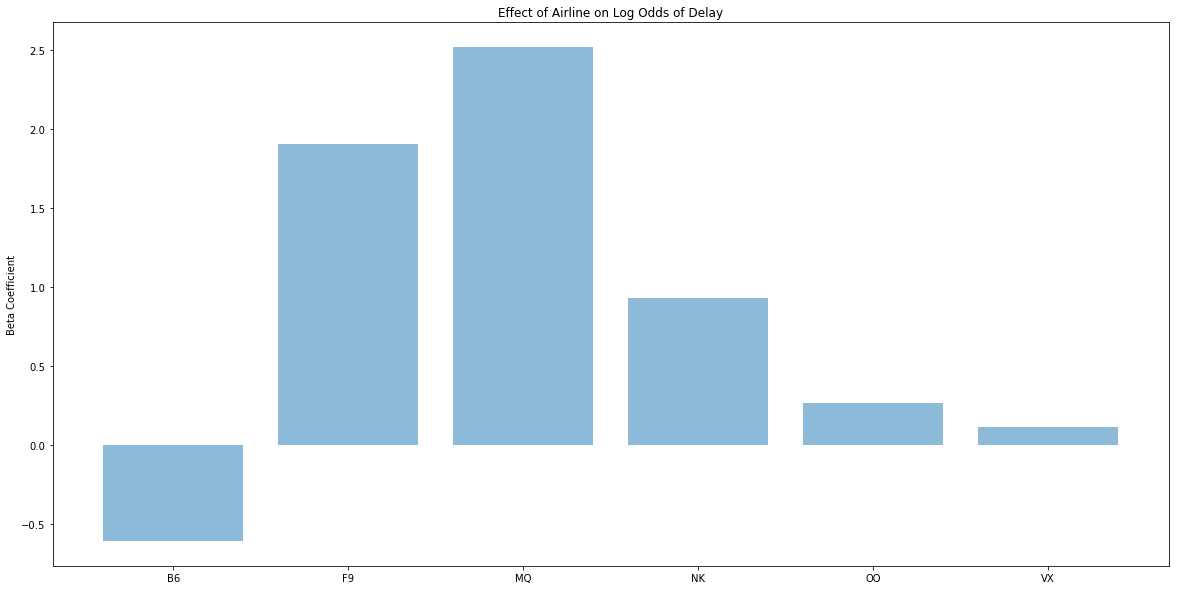

In [24]:
airlines_predictors = [ele for ele in significant_predictors 
                       if ele[1].startswith('AIRLINE')]
airline = [ele[1].replace('AIRLINE_','') for ele 
           in airlines_predictors]
beta = [ele[2] for ele in airlines_predictors]

airline_index = range(1,len(airline)+1)

labels = []
for ele in airline:
    labels.append(ele)

plt.figure(figsize=(20,10))
plt.bar(airline_index, beta, align='center', alpha=0.5, )
plt.xticks(airline_index, labels)
plt.ylabel('Beta Coefficient')
plt.title('Effect of Airline on Log Odds of Delay')
plt.show()

In [58]:
# Logistic Regression on Validation Set (Rest of Data Set)

print("Logistic Validation Score: ", 
      logitm.score(X_validation, y_validation))

Logistic Validation Score:  0.956398245573


### Question 7

In [61]:
df = pd.read_csv('cs109a_midterm.csv')
df = df[df['ARRIVAL_DELAY'] >= 15]

# Take Log of ARRIVAL_DELAY
df['ARRIVAL_DELAY'] = np.log(df['ARRIVAL_DELAY'])

# Select only relevant variables
numerical_columns = ['SCHED_DEP','SCHED_ARR',
                     'DEPARTURE_DELAY','DISTANCE',
                     'SCHEDULED_TIME']
categorical_columns = ['MONTH','DAY','DAY_OF_WEEK',
                       'AIRLINE','ORIGIN_AIRPORT',
                       'DESTINATION_AIRPORT']

df = df[categorical_columns + numerical_columns + 
        ['ARRIVAL_DELAY']]

df = pd.get_dummies(df, columns=categorical_columns, 
                    drop_first=True)

def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

df['SCHED_DEP'] = df['SCHED_DEP'].apply(get_sec)
df['SCHED_ARR'] = df['SCHED_ARR'].apply(get_sec)

In [62]:
# Split train and test sets

np.random.seed(9002)

# split data into 5% training & test, 95% validation
model_df, validation_df = train_test_split(df, train_size=0.05)

# split model data into 50% training, 50% test
train_df, test_df = train_test_split(model_df, train_size=0.5)

In [77]:
# Standardize continuous variables
mean = train_df[numerical_columns].mean()
std = train_df[numerical_columns].std()

train_df[numerical_columns] = 
    (train_df[numerical_columns] - mean)/std
test_df[numerical_columns] = 
    (test_df[numerical_columns] - mean)/std
validation_df[numerical_columns] = 
    (validation_df[numerical_columns] - mean)/std

train_df.head()

/Users/emilychen1/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,SCHED_DEP,SCHED_ARR,DEPARTURE_DELAY,DISTANCE,SCHEDULED_TIME,ARRIVAL_DELAY,MONTH_2,MONTH_3,MONTH_4,MONTH_5,...,DESTINATION_AIRPORT_TYS,DESTINATION_AIRPORT_UST,DESTINATION_AIRPORT_VEL,DESTINATION_AIRPORT_VLD,DESTINATION_AIRPORT_VPS,DESTINATION_AIRPORT_WRG,DESTINATION_AIRPORT_WYS,DESTINATION_AIRPORT_XNA,DESTINATION_AIRPORT_YAK,DESTINATION_AIRPORT_YUM
334064,0.531878,0.767407,-0.195004,0.522822,0.312904,4.060443,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
606459,-0.660318,0.085310,-0.508820,1.308004,1.438111,3.555348,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
338792,-0.249890,-0.084443,-0.442753,-0.706012,-0.705141,3.135494,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134915,-1.887693,-0.578270,-0.244554,1.353206,1.156809,4.043051,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
264159,1.270649,-2.214070,-0.062871,2.051331,1.719413,3.433987,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
# OLS Model

X_train = sm.add_constant(train_df.drop('ARRIVAL_DELAY', axis=1))
X_test = sm.add_constant(test_df.drop('ARRIVAL_DELAY', axis=1))
X_validation = sm.add_constant(validation_df.drop('ARRIVAL_DELAY', axis=1))
y_train = train_df['ARRIVAL_DELAY'].values.reshape(-1,1)
y_test = test_df['ARRIVAL_DELAY'].values.reshape(-1,1)
y_test = validation_df['ARRIVAL_DELAY'].values.reshape(-1,1)

model = OLS(endog=y_train, exog=X_train)
ols = model.fit()

y_hat_train = ols.predict()
y_hat_test = ols.predict(exog=X_test)

print('OLS Train R^2: ', r2_score(train_df['ARRIVAL_DELAY'], y_hat_train))
print('OLS Test R^2: ', r2_score(test_df['ARRIVAL_DELAY'], y_hat_test))

OLS Train R^2:  0.765269991077
OLS Test R^2:  0.615986608026


In [65]:
# Ridge Regression Model

lambdas = [.001,.005,1,5,10,50,100,500,1000]

ridge = RidgeCV(alphas=lambdas, fit_intercept=False, 
                normalize=True)
ridge.fit(X_train, y_train)

print('Ridge Train R^2: ', ridge.score(X_train, y_train))
print('Ridge Test R^2: ', ridge.score(X_test, y_test))

Ridge Train R^2:  0.72136147228
Ridge Test R^2:  0.688609626158


In [66]:
# LASSO Regression Model
lasso = LassoCV(cv=10, alphas=lambdas, fit_intercept=False, 
                normalize=False)
preprocessing.StandardScaler()
lasso.fit(X_train, y_train)

print('LASSO Train R^2: ', lasso.score(X_train, y_train))
print('LASSO Test R^2: ', lasso.score(X_test, y_test))

/Users/emilychen1/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LASSO Train R^2:  0.706383057134
LASSO Test R^2:  0.704987608446


#### Linear Regression with Polynomial Terms

In [80]:
# Transform Predictors to Include Quadratic Terms

X_train_binary_only = X_train.drop(numerical_columns, axis=1)
X_test_bin_only = X_test.drop(numerical_columns, axis=1)
X_validation_bin_only = X_validation.drop(numerical_columns, axis=1)
X_train_poly = X_train_binary_only.copy()
X_test_poly = X_test_bin_only.copy()
X_validation_poly = X_validation_bin_only.copy()

poly = PolynomialFeatures(2, include_bias=False)
for col in numerical_columns:
    for i in range(1,3):
        X_train_poly[col + '_' + str(i)] = X_train[col]**i
        X_test_poly[col + '_' + str(i)] = X_test[col]**i
        X_validation_poly[col + '_' + str(i)] = X_validation[col]**i

In [68]:
# OLS with Polynomial Terms

ols_poly = OLS(y_train, X_train_poly).fit()
ols_poly.summary()

y_hat_train = ols_poly.predict()
y_hat_test = ols_poly.predict(exog=X_test_poly)

print('OLS with Polynomial Terms Train R^2: ', 
      r2_score(train_df['ARRIVAL_DELAY'], y_hat_train))
print('OLS with Polynomial Terms Test R^2: ', 
      r2_score(test_df['ARRIVAL_DELAY'], y_hat_test))

OLS with Polynomial Terms Train R^2:  0.827676128487
OLS with Polynomial Terms Test R^2:  0.70387121825


/Users/emilychen1/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/emilychen1/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/emilychen1/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/emilychen1/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [69]:
# Ridge with Polynomial Terms Regression Model

lambdas = [.001,.005,1,5,10,50,100,500,1000]

ridge_poly = RidgeCV(alphas=lambdas, fit_intercept=False, 
                     normalize=True)
ridge_poly.fit(X_train_poly, y_train)

print('Ridge with Polynomial Terms Train R^2: ', 
      ridge_poly.score(X_train_poly, y_train))
print('Ridge with Polynomial Terms Test R^2: ', 
      ridge_poly.score(X_test_poly, y_test))

Ridge with Polynomial Terms Train R^2:  0.790902615727
Ridge with Polynomial Terms Test R^2:  0.758520779654


In [70]:
# LASSO with Polynomial Terms Regression Model
lasso_poly = LassoCV(cv=10, alphas=lambdas, 
                     fit_intercept=False, normalize=False)
lasso_poly.fit(X_train_poly, y_train)

print('LASSO with Polynomial Terms Train R^2: ', 
      lasso_poly.score(X_train_poly, y_train))
print('LASSO with Polynomial Terms Test R^2: ', 
      lasso_poly.score(X_test_poly, y_test))

/Users/emilychen1/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LASSO with Polynomial Terms Train R^2:  0.764222837376
LASSO with Polynomial Terms Test R^2:  0.776481080972


#### Linear Regression with Polynomial & Interaction Terms

In [71]:
X_train_interact = X_train_poly.copy()
X_test_interact = X_test_poly.copy()

# Additional interaction terms between certain months 
# and distance, and day-of-week with scheduled 
# departure and arrival times

X_train_interact['NOV_DISTANCE'] = 
    X_train['MONTH_11'] * X_train['DISTANCE']
X_train_interact['DEC_DISTANCE'] = 
    X_train['MONTH_12'] * X_train['DISTANCE']
X_train_interact['TUES_SCHED_DEP'] = 
    X_train['DAY_OF_WEEK_2'] * X_train['SCHED_DEP']
X_train_interact['WED_SCHED_DEP'] = 
    X_train['DAY_OF_WEEK_3'] * X_train['SCHED_DEP']
X_train_interact['THU_SCHED_DEP'] = 
    X_train['DAY_OF_WEEK_4'] * X_train['SCHED_DEP']
X_train_interact['FRI_SCHED_DEP'] = 
    X_train['DAY_OF_WEEK_5'] * X_train['SCHED_DEP']
X_train_interact['SAT_SCHED_DEP'] = 
    X_train['DAY_OF_WEEK_6'] * X_train['SCHED_DEP']
X_train_interact['SUN_SCHED_DEP'] = 
    X_train['DAY_OF_WEEK_7'] * X_train['SCHED_DEP']
X_train_interact['TUES_SCHED_ARR'] = 
    X_train['DAY_OF_WEEK_2'] * X_train['SCHED_ARR']
X_train_interact['WED_SCHED_ARR'] = 
    X_train['DAY_OF_WEEK_3'] * X_train['SCHED_ARR']
X_train_interact['THU_SCHED_ARR'] = 
    X_train['DAY_OF_WEEK_4'] * X_train['SCHED_ARR']
X_train_interact['FRI_SCHED_ARR'] = 
    X_train['DAY_OF_WEEK_5'] * X_train['SCHED_ARR']
X_train_interact['SAT_SCHED_ARR'] = 
    X_train['DAY_OF_WEEK_6'] * X_train['SCHED_ARR']
X_train_interact['SUN_SCHED_ARR'] = 
    X_train['DAY_OF_WEEK_7'] * X_train['SCHED_ARR']

                                                            
X_test_interact['NOV_DISTANCE'] = 
    X_test['MONTH_11'] * X_test['DISTANCE']
X_test_interact['DEC_DISTANCE'] = 
    X_test['MONTH_12'] * X_test['DISTANCE']
X_test_interact['TUES_SCHED_DEP'] = 
    X_test['DAY_OF_WEEK_2'] * X_test['SCHED_DEP']
X_test_interact['WED_SCHED_DEP'] = 
    X_test['DAY_OF_WEEK_3'] * X_test['SCHED_DEP']
X_test_interact['THU_SCHED_DEP'] = 
    X_test['DAY_OF_WEEK_4'] * X_test['SCHED_DEP']
X_test_interact['FRI_SCHED_DEP'] = 
    X_test['DAY_OF_WEEK_5'] * X_test['SCHED_DEP']
X_test_interact['SAT_SCHED_DEP'] = 
    X_test['DAY_OF_WEEK_6'] * X_test['SCHED_DEP']
X_test_interact['SUN_SCHED_DEP'] = 
    X_test['DAY_OF_WEEK_7'] * X_test['SCHED_DEP']
X_test_interact['TUES_SCHED_ARR'] = 
    X_test['DAY_OF_WEEK_2'] * X_test['SCHED_ARR']
X_test_interact['WED_SCHED_ARR'] = 
    X_test['DAY_OF_WEEK_3'] * X_test['SCHED_ARR']
X_test_interact['THU_SCHED_ARR'] = 
    X_test['DAY_OF_WEEK_4'] * X_test['SCHED_ARR']
X_test_interact['FRI_SCHED_ARR'] = 
    X_test['DAY_OF_WEEK_5'] * X_test['SCHED_ARR']
X_test_interact['SAT_SCHED_ARR'] = 
    X_test['DAY_OF_WEEK_6'] * X_test['SCHED_ARR']
X_test_interact['SUN_SCHED_ARR'] = 
    X_test['DAY_OF_WEEK_7'] * X_test['SCHED_ARR']

In [72]:
# OLS with Polynomial & Interaction Terms

ols_interact = OLS(y_train, X_train_interact).fit()
ols_interact.summary()

y_hat_train = ols_interact.predict()
y_hat_test = ols_interact.predict(exog=X_test_interact)

print('OLS with Polynomial & Interaction Terms Train R^2: ', 
      r2_score(train_df['ARRIVAL_DELAY'], y_hat_train))
print('OLS with Polynomial & Interaction Terms Test R^2: ', 
      r2_score(test_df['ARRIVAL_DELAY'], y_hat_test))

OLS with Polynomial & Interaction Terms Train R^2:  0.828724325361
OLS with Polynomial & Interaction Terms Test R^2:  0.701874902507


/Users/emilychen1/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/emilychen1/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/emilychen1/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/emilychen1/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [73]:
# Ridge with Polynomial & Interaction Terms Regression Model

lambdas = [.001,.005,1,5,10,50,100,500,1000]

ridge_interact = RidgeCV(alphas=lambdas, fit_intercept=False, 
                         normalize=True)
ridge_interact.fit(X_train_interact, y_train)

print('Ridge with Polynomial & Interaction Terms Train R^2: ', 
      ridge_interact.score(X_train_interact, y_train))
print('Ridge with Polynomial & Interaction Terms Test R^2: ', 
      ridge_interact.score(X_test_interact, y_test))

Ridge with Polynomial & Interaction Terms Train R^2:  0.791608001444
Ridge with Polynomial & Interaction Terms Test R^2:  0.756993859211


In [74]:
# LASSO with Polynomial & Interaction Terms Regression Model
lasso_interact = LassoCV(cv=10, alphas=lambdas, 
                         fit_intercept=False, normalize=False)
lasso_interact.fit(X_train_interact, y_train)

print('LASSO with Polynomial & Interaction Terms Train R^2: ', 
      lasso_interact.score(X_train_interact, y_train))
print('LASSO with Polynomial & Interaction Terms Test R^2: ', 
      lasso_interact.score(X_test_interact, y_test))

/Users/emilychen1/anaconda/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1082: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LASSO with Polynomial & Interaction Terms Train R^2:  0.764224143218
LASSO with Polynomial & Interaction Terms Test R^2:  0.776481783292


<h1><center>$R^2$ Values</center></h1>

|     |Standard (Given Terms) |Polynomial Terms      |Polynomial & Interaction Terms|
|-----|-----------------------|----------------------|------------------------------|
| OLS | Train: 0.765269991077 | Train: 0.827676128487| Train: 0.828724325361        |
|     | Test: 0.615986608026  | Test: 0.70387121825  | Test: 0.701874902507         |
|Ridge| Train: 0.72136147228  | Train: 0.790902615727| Train: 0.791608001444        |
|     | Test: 0.688609626158  | Test: 0.758520779654 | Test: 0.756993859211         |
|LASSO| Train: 0.706383057134 | Train: 0.764222837376| Train: 0.764224143218        |
|     | Test: 0.704987608446  | Test: 0.776481080972 | Test: 0.776481783292         |


In [48]:
significant_predictors = 
    ols_interact.pvalues[(ols_interact.pvalues < 0.05)]
print('Number of significant predictors: ', 
      len(significant_predictors))
significant_predictors

Number of significant predictors:  68


const                        2.050169e-304
MONTH_9                       2.141080e-02
MONTH_11                      1.701057e-02
DAY_13                        3.261474e-02
DAY_OF_WEEK_6                 3.318749e-03
AIRLINE_DL                    2.127683e-02
AIRLINE_UA                    1.208231e-02
AIRLINE_US                    1.381882e-02
AIRLINE_WN                    1.129860e-03
ORIGIN_AIRPORT_10157          9.777978e-03
ORIGIN_AIRPORT_10158          4.593727e-02
ORIGIN_AIRPORT_10279          4.817064e-02
ORIGIN_AIRPORT_10397          2.294287e-02
ORIGIN_AIRPORT_10529          3.500022e-02
ORIGIN_AIRPORT_10739          3.715516e-02
ORIGIN_AIRPORT_10800          3.167306e-02
ORIGIN_AIRPORT_11481          2.399873e-02
ORIGIN_AIRPORT_11823          4.378325e-02
ORIGIN_AIRPORT_11953          3.106824e-02
ORIGIN_AIRPORT_11995          2.802894e-02
ORIGIN_AIRPORT_12173          3.860965e-02
ORIGIN_AIRPORT_12323          3.129930e-02
ORIGIN_AIRPORT_12896          4.835561e-02
ORIGIN_AIRP

In [82]:
# OLS with Polynomial Terms Regression on Validation Set (Rest of Data Set)

y_hat_validation = 
    ols_poly.predict(exog=X_validation_poly)

print('OLS with Polynomial Terms Test R^2: ', 
      r2_score(validation_df['ARRIVAL_DELAY'], y_hat_validation))

OLS with Polynomial Terms Test R^2:  -1.92104913154e+16


The model I decided upon to model the length of (arrival) delay is the Orindary Least Squares Linear Regression Model with quadratic terms and interaction terms. The subset predictors that are statistically significant at the 0.05 level for this linear model are listed above.

### Question 8

#### Model 1:
The goal is to fit a classification model for the binary response variable 'DELAY_OR_NOT'. 

First, I select 2.5% of the data to be my training set, another 2.5% for the test set, and the remaining 95% as the validation set that may lend larger-scale understanding to the model we fit on the training set (and tested on the test set). Though this percentage seems small, I believe this is a reasonable breakdown, given that there are 800,000+ observations in the data set that may causes computational challenges.

Next comes the formatting of the data. After adding the 'DELAY_OR_NOT' column, I've one-hot encoded all the categorical variables and standardized each column. Though this adds many extra predictors to the data frame, PCA is not necessary due to the much larger size of the data set.

In fitting this classification model, I have gone through multiple approaches above (Question 4), including Multiple Logistic Regression, LDA, QDA, k-Nearest Neigbors, and Decision Trees. I examined ROC curves and AUC, in addition to classification accuracy, to determine the best model. Multiple Logistic Regression yields the best result as well as a high accuracy score of 0.956398245573 on the validation set. I was easily able to rule out QDA (which had low accruacy and  AUC scores) and the non-parametric kNN and Decision Tree models that are computationally and memory inefficient given this large data set. I then boostrapped 100 iterations to determine which of the predictors in the model are actually significant at the 0.05 level.

#### Model 2:
The goal here is to fit a regression model to predict the length of a delay, given that a flight is delayed.

I first limit the data to only those where a flight is actually delayed. Then, I process the data very similarly to how I did for Model 1 (described above).

I fit models for OLS regression on the standard set of all predictors, predictors with polynomial terms (quadratic continuous predictors), and then predictors with polynomial and certain interaction terms of interest. I then repeat this using LASSO and Ridge regression (since stepwise regression would be extremely inefficient with the large number of predictors). Evaluating $R^2$ values for the test set, OLS with polynomial terms seems is the best. We then select only those predictors that are statistically significant at the 0.05 level.




### 209 Additional questions
1. (10pts) Engineer two additional features that will help improve the classification model's performance.
2. (5pts) Add one additional feature from a data source not given to you.  Do this only after you complete the rest of the exam.

## Deliverable: 
A well presented notebook with well structured and documented code to answer questions 1-7 (plus additional questions for 209 students) with brief explanations and/or clarifications (10pts for overall presenation). The last cell should contain the report for question 8.



## Hints
1. For the classification model, an AUC of approximately 0.6 should be your base model. 
2. $R^2>0.03$ for the regression is good, $R^2>0.05$ very good, and $R^2>0.1$ is impressive (measured on the log scale). 